# Plots for the paper concerning the EWino scan

In [2]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

/tmp/ipykernel_11748/1618832188.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import glob,imp,os,shutil
/tmp/ipykernel_11748/1618832188.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


#### Create txname/process translator

In [3]:
# processDict = {'TChiWZ' : r'$\tilde{\chi}_1^\pm \, \tilde{\chi}_2^0 \to W^{(*)} Z^{(*)}\, \tilde{\chi}_1^0 \tilde{\chi}_1^0$',
#               'TChiWH' : r'$\tilde{\chi}_1^\pm \, \tilde{\chi}_2^0 \to W h\, \tilde{\chi}_1^0 \tilde{\chi}_1^0$',
#               'TChiWW' : r'$\tilde{\chi}_1^\pm \, \tilde{\chi}_1^\mp \to W W \, \tilde{\chi}_1^0 \tilde{\chi}_1^0$',
#               'TDTM1F,TDTM2F' : r'$\tilde{\chi}_1^\pm \to \pi^\pm \tilde{\chi}_1^0$, DT'}
# def convertLabel(label):
#     newlabel = label[:]
#     #Replace txnames by process
#     for txlabel,proc in processDict.items():
#         newlabel = newlabel.replace(txlabel,proc) 
#     #Remove off-shell Ws and Zs from ATLAS analyses (since they only appear in on-shell cases)
#     if 'ATLAS' in newlabel:
#         newlabel = newlabel.replace('W^{(*)} Z^{(*)}', 'W Z')
#     return newlabel

In [4]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('/home/yoxara/2MDM/notebooks/SmodelS/2MDM_scanResults_all.pcl')
print(dataDF.columns.values.tolist()) #Print all columns names

['filename', 'mass.9000006', 'mass.9900032', 'mass.9900026', 'width.9000006', 'width.9900026', 'width.9900032', 'extpar.1', 'extpar.2', 'extpar.3', 'extpar.4', 'xsec13TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.zp.b,b', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.t-,t+', 'BRs.zp.chi,chi', 'BRs.sd.chi,chi', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'SMS Decomposition', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'OutputStatus.sigmacut', 'OutputStatus.minmassgap', 'OutputStatus.maxcond', 'OutputStatus.ncpus', 'OutputStatus.model', 'OutputStatus.promptwidth', 'OutputStatus.stablewidth', 'OutputStatus.eraseprompt', 'OutputStatus.checkinput', 'OutputStatus.doinvisible', 'OutputStatus.docompress', 'OutputStatus.computestatistics', 'OutputStatus.testcoverage

#### Set r = 0 for points with no results 

In [5]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [6]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [17]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 1870
Total excluded (LHC) = 132
Total allowed = 1738



### Create analysis label for excluded points

In [8]:
anas = excluded['ExptRes.result0.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result0.AnalysisID']
    txList = sorted(row['ExptRes.result0.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    label = label.replace('off','') #Group together on and off-shell topologies
    labels.append(label)
excluded['label'] = labels


In [9]:
nexcluded = [[len(excluded[excluded['label'] == label]),label] for label in excluded['label'].unique()]
nexcluded = sorted(nexcluded,reverse=True)
nexcluded = np.array(nexcluded)
for label in nexcluded[:,1]:
    print(label+': %i'%len(excluded[excluded['label'] == label]))

CMS-EXO-20-004 (TRS1,TRV1): 90
CMS-PAS-EXO-20-008 (TRV1bb): 42


### Define colors and plotting order

/tmp/ipykernel_11748/4174325670.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu_r')


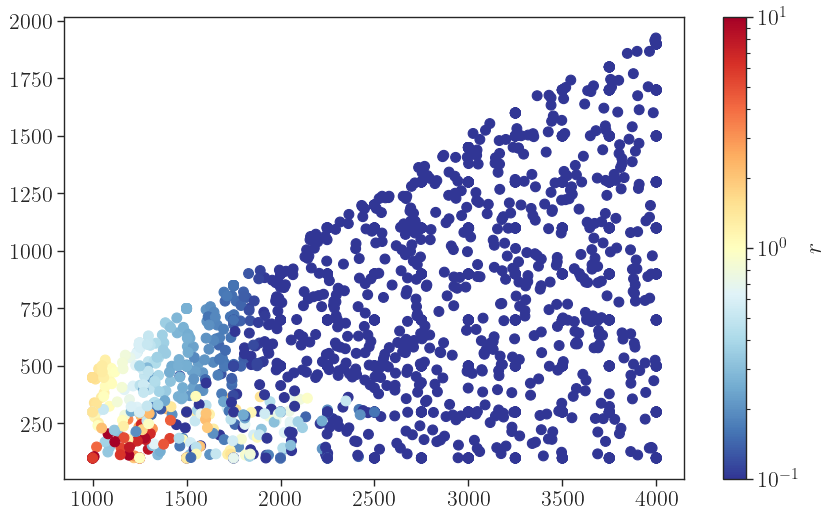

In [10]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(10,6))
x = dataDF['mass.9900032']
y = dataDF['mass.9000006']
c = dataDF['ExptRes.result0.r']
x = x[c.argsort()]
y = y[c.argsort()]
c = c[c.argsort()]

plt.scatter(x,y,c=c,s=50,cmap=cm, norm=LogNorm(vmin=1e-1,vmax=1e1))
# # plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$r$')
# plt.xlabel(r'$M_2/\mu$ (GeV)')
# plt.ylabel(r'$M_2/M_1$ (GeV)')
# # plt.ylim(-1,10)
# plt.xscale('log')
# plt.yscale('log')
# plt.text(0.7,10.0,r"{\bf Bino LSP}",fontsize=16,color='white')
# plt.text(0.05,0.1,r"{\bf Wino LSP}",fontsize=16,color='white')
# plt.text(2.,0.6,r"{\bf Higgsino LSP}",fontsize=16)

# plt.tight_layout()
# plt.savefig('charginoLifetime.png')
plt.show()

### Neutralino Branching ratio

In [14]:
deleteCurves = ['CMS-PAS-EXO-20-008','CMS-EXO-20-004']
anas = excluded['label'].value_counts()
anas.sort_values(inplace=True,ascending=False)

plt.figure(figsize=(10,6))

cm = plt.cm.get_cmap('RdYlBu_r')
x = dataDF['mass.9900032']
y = dataDF['mass.9000006']
c = dataDF['ExptRes.result0.r']
for ana in anas.index:
    if not ana in excCurves: continue
    if any(val in ana for val in deleteCurves): continue
    curve = excCurves[ana]
    color = colorDict[ana]
    plt.plot(curve[:,0],curve[:,1],linewidth=3,linestyle='-',color=color)

plt.scatter(x,y,c=c,s=50,cmap=cm)
# plt.plot([x.min(),x.max()],[x.min(),x.max()],'--')
plt.colorbar(label=r'$BR(\tilde \chi_2^0 \to \tilde \chi_1^0 +Z)$')
plt.xlabel(r'$m_{\tilde{\chi}_1^\pm}$ (GeV)')
plt.ylabel(r'$m_{\tilde{\chi}_1^0}$ (GeV)')
plt.ylim(0,600)
plt.xlim(0,800)
plt.tight_layout()
plt.show()

/tmp/ipykernel_11748/1370493293.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu_r')


NameError: name 'excCurves' is not defined

<Figure size 1000x600 with 0 Axes>